In [1]:
import os
import argparse
import json
import torch
import torch.utils.data as data
import pytorch_lightning as pl 
from pytorch_lightning.callbacks import ModelCheckpoint
from shutil import copyfile
import numpy as np
from experiments.utils import train_model, load_datasets, get_default_parser, print_params
import warnings

import sys
sys.path.append('../')
from experiments.datasets import VoronoiDataset, CausalWorldDataset, iTHORDataset

# data_dir = '/home/john/PhD/BISCUIT/data_generation/data/ithor/train/'
# data = np.load(data_dir + 'train_seq_3293867794.npz')

In [2]:
def get_default_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', type=str, default='/home/john/PhD/BISCUIT/data/ithor')
    parser.add_argument('--cluster', action="store_true")
    parser.add_argument('--seed', type=int, default=42)
    parser.add_argument('--max_epochs', type=int, default=200)
    parser.add_argument('--debug', action='store_true')
    parser.add_argument('--offline', action='store_true')
    parser.add_argument('--batch_size', type=int, default=128)
    parser.add_argument('--num_workers', type=int, default=4)
    parser.add_argument('--data_img_width', type=int, default=-1)
    parser.add_argument('--seq_len', type=int, default=2)
    parser.add_argument('--lr', type=float, default=1e-3)
    parser.add_argument('--warmup', type=int, default=100)
    parser.add_argument('--check_val_every_n_epoch', type=int, default=-1)
    parser.add_argument('--logger_name', type=str, default='')
    parser.add_argument('--files_to_save', type=str, nargs='+', default='')
    parser.add_argument('--compile', action='store_true')
    return parser

parser = get_default_parser()
parser.add_argument('--autoencoder_checkpoint', type=str,
                    required=True)
parser.add_argument('--c_hid', type=int, default=64)
parser.add_argument('--num_flows', type=int, default=6)
parser.add_argument('--num_samples', type=int, default=2)
parser.add_argument('--flow_act_fn', type=str, default='silu')
parser.add_argument('--hidden_per_var', type=int, default=16)
parser.add_argument('--act_fn', type=str, default='silu')
parser.add_argument('--num_latents', type=int, default=40)
parser.add_argument('--prior_action_add_prev_state', action="store_true")
parser.add_argument('--try_encodings', type=bool, default=False)
parser.add_argument('--logit_reg_factor', type=float, default=0.004)
parser.add_argument('--text', default=False, action="store_true")
parser.add_argument('--lr_text', type=float, default=1e-4, help='Learning rate for text model')
parser.add_argument('--wandb', default=True, action="store_true")
parser.add_argument('--text_encoder', type=str, default='sentence_transformer', help='Which text encoder to use')
parser.add_argument('--subsample_percentage', type=float, default=1.0)
parser.add_argument('--debug_data', default=False, action="store_true")
parser.add_argument('--perfect_interactions', default=False, action="store_true")


args = parser.parse_args(['--autoencoder_checkpoint', '/home/john/PhD/BISCUIT/pretrained_models/AE_40l_64hid.ckpt'])

In [3]:
datasets = load_datasets(args)

In [3]:
action_dataset = iTHORDataset(data_folder=args.data_dir,
                                   split='train',
                                   return_robot_state=True,
                                   triplet=False,
                                   return_targets=True,
				   return_latents=True,
                                   return_text=args.text,
                                   try_encodings=args.try_encodings,)
action_loader = data.DataLoader(action_dataset,
                                batch_size=args.batch_size,
                                shuffle=False,
                                num_workers=args.num_workers,
                                pin_memory=True,
                                drop_last=False)

Loading sequences of train:   0%|          | 0/75 [00:00<?, ?it/s]

In [6]:
interaction_categories = {
    "Egg_broken": [1],  # Egg broken
    "Egg": [2, 3, 4, 6],  # Egg-related interactions
    # "Egg_pickedup": [6],
    "Egg_cooked": [5],  # Egg cooked
    "Plate": [9, 10, 11, 12],  # Plate-related interactions
    "Cabinet_open": [0],
    "Microwave_on": [7],
    "Microwave_open": [8],
    "StoveKnob1_on": [13],
    "StoveKnob2_on": [14],
    "StoveKnob3_on": [15],
    "StoveKnob4_on": [16],
    "Toaster_on": [17]
}

def calculate_interaction_distribution(dataloader, categories):
    distribution = {category: 0 for category in categories.keys()}

    for batch in dataloader:
        interaction_vectors = batch[2]
        for interaction in interaction_vectors:
            interaction = interaction.squeeze()  # Remove batch dimension
            for category, indices in categories.items():
                if any(interaction[idx] == 1 for idx in indices):
                    distribution[category] += 1

    return distribution

interaction_distribution = calculate_interaction_distribution(action_loader, interaction_categories)
interaction_distribution


{'Egg_broken': 140,
 'Egg': 579,
 'Egg_cooked': 140,
 'Plate': 1216,
 'Cabinet_open': 527,
 'Microwave_on': 352,
 'Microwave_open': 382,
 'StoveKnob1_on': 507,
 'StoveKnob2_on': 550,
 'StoveKnob3_on': 584,
 'StoveKnob4_on': 546,
 'Toaster_on': 547}

In [5]:
def subsample_dataset(dataloader, N):
    """
    Function to subsample the dataset to ensure exactly N samples for each interaction category.

    Args:
    dataloader (iterable): An iterable that yields batches of data (images, actions, causal_vars).
    N (int): The desired number of samples for each interaction category.

    Returns:
    dict: A dictionary with interaction category as keys and lists of indices as values.
    """
    category_counts = {category: 0 for category in interaction_categories.keys()}
    selected_indices = {category: [] for category in interaction_categories.keys()}

    # Process each batch
    for batch_index, batch in enumerate(dataloader):
        images, actions, causal_vars, latents = batch

        for sample_index, interaction in enumerate(causal_vars):
            interaction = interaction.squeeze()
            for category, indices in interaction_categories.items():
                if any(interaction[idx] == 1 for idx in indices):
                    if category_counts[category] < N:
                        selected_indices[category].append(batch_index * len(images) + sample_index)
                        category_counts[category] += 1
    for category, count in category_counts.items():
        if count < N:
            warnings.warn(f"Category {category} has only {count} samples.")

    return selected_indices

N = 37  # For example, to get 5 samples of each interaction
subsampled_indices = subsample_dataset(action_loader, N)
# subsampled_indices



In [8]:
import random

def build_category_indices(dataloader):
    """
    Builds indices for each interaction category in the dataset, considering the batch structure.

    Args:
        dataloader (iterable): An iterable that yields batches of data.

    Returns:
        dict: A dictionary with interaction categories as keys and lists of indices as values.
    """
    category_counts = {category: 0 for category in interaction_categories.keys()}
    category_indices = {category: [] for category in interaction_categories.keys()}

    # Process each batch
    for batch_index, batch in enumerate(dataloader):
        # Assuming the third element in the batch contains the interaction vectors
        interaction_vectors = batch[2]  # Adjust this based on the actual data structure

        for sample_index, interaction in enumerate(interaction_vectors):
            interaction = interaction.squeeze()  # Remove any extra dimensions
            for category, indices in interaction_categories.items():
                if any(interaction[idx] == 1 for idx in indices):
                    # Add to category indices and increment the count
                    index = batch_index * len(interaction_vectors) + sample_index
                    category_indices[category].append(index)
                    category_counts[category] += 1

    return category_counts, category_indices



indices = build_category_indices(action_loader)

In [ ]:
def subsample_dataset_maintaining_distribution(dataloader, ss_percent, seed=None):
    """
    Subsamples the dataset to a specified percentage of its original size while approximating the fair distribution of interaction categories.

    Args:
        dataloader (iterable): An iterable that yields batches of data.
        ss_percent (float): The percentage of the original dataset size to subsample.
        seed (int, optional): A seed for the random number generator for reproducibility.

    Returns:
        dict: A dictionary with interaction categories as keys and lists of selected indices as values.
    """
    if seed is not None:
        random.seed(seed)

    # Build indices for each category
    category_counts, category_indices = build_category_indices(dataloader)

    # Calculate the target number of unique samples for the subsample
    total_unique_samples = dataloader.dataset.__len__()
    target_unique_samples = int(total_unique_samples * (ss_percent / 100))

    # Combine all indices and sample from this set
    combined_indices = list(set().union(*category_indices.values()))
    sampled_indices = random.sample(combined_indices, min(len(combined_indices), target_unique_samples))

    # Initialize the subsampled indices
    subsampled_indices = {category: [] for category in interaction_categories.keys()}

    # Allocate sampled indices to each category, prioritizing proportional distribution
    for index in sampled_indices:
        for category, indices in category_indices.items():
            if index in indices:
                # Check if adding this index keeps the proportionate distribution
                current_percentage = len(subsampled_indices[category]) / category_counts[category]
                target_percentage = ss_percent / 100
                if current_percentage < target_percentage:
                    subsampled_indices[category].append(index)

    return subsampled_indices




subsampled_indices = subsample_dataset_maintaining_distribution(action_loader, 50, seed=42)

In [9]:
indices[0]

{'Egg_broken': 140,
 'Egg': 579,
 'Egg_cooked': 140,
 'Plate': 1216,
 'Cabinet_open': 527,
 'Microwave_on': 352,
 'Microwave_open': 382,
 'StoveKnob1_on': 507,
 'StoveKnob2_on': 550,
 'StoveKnob3_on': 584,
 'StoveKnob4_on': 546,
 'Toaster_on': 547}

In [10]:
{k:len(x) for k,x in subsampled_indices.items()}

{'Egg_broken': 37,
 'Egg': 37,
 'Egg_cooked': 37,
 'Plate': 37,
 'Cabinet_open': 37,
 'Microwave_on': 37,
 'Microwave_open': 37,
 'StoveKnob1_on': 37,
 'StoveKnob2_on': 37,
 'StoveKnob3_on': 37,
 'StoveKnob4_on': 37,
 'Toaster_on': 37}

In [ ]:
action_dataset.__len__()

In [ ]:
len(set().union(*subsampled_indices.values()))

In [ ]:
print(subsampled_indices)
indices = set().union(*subsampled_indices.values())
print(indices)

In [12]:
from torch.utils.data import Subset
from torch.utils.data import DataLoader

# Create a subset of the dataset using the indices, including the original dataset's indices
subset = Subset(action_dataset, indices)
egg_broken_subset = Subset(action_dataset, subsampled_indices['Egg_broken'])
Microwave_on_subset = Subset(action_dataset, subsampled_indices['Microwave_on'])
# egg_pickedup_subset = Subset(action_dataset, subsampled_indices['Egg_pickedup'])
egg_cooked_subset = Subset(action_dataset, subsampled_indices['Egg_cooked'])

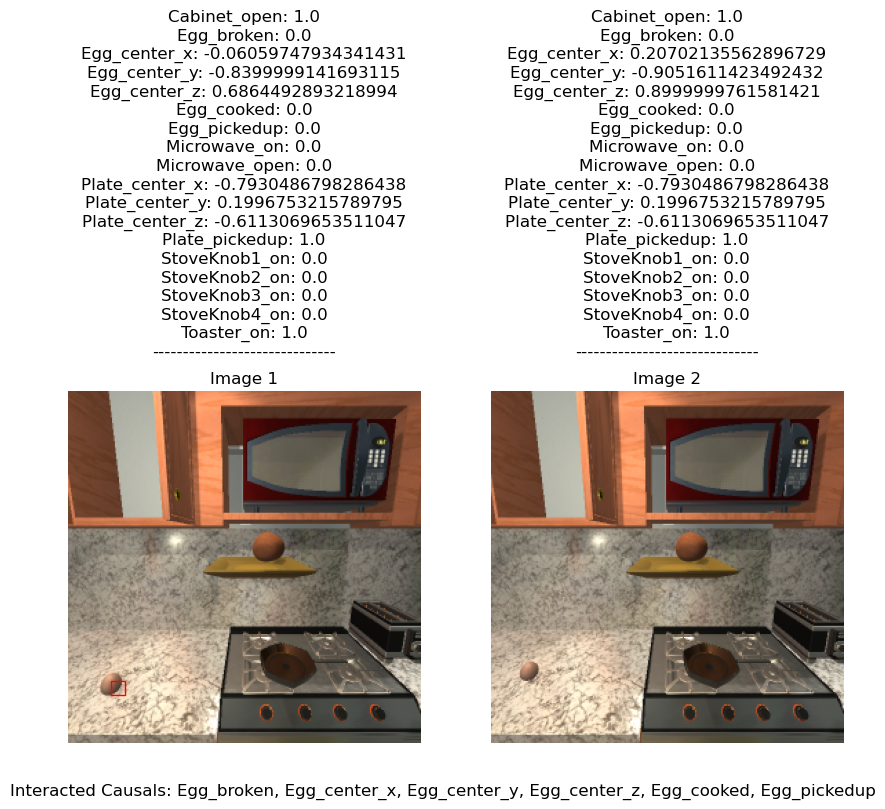

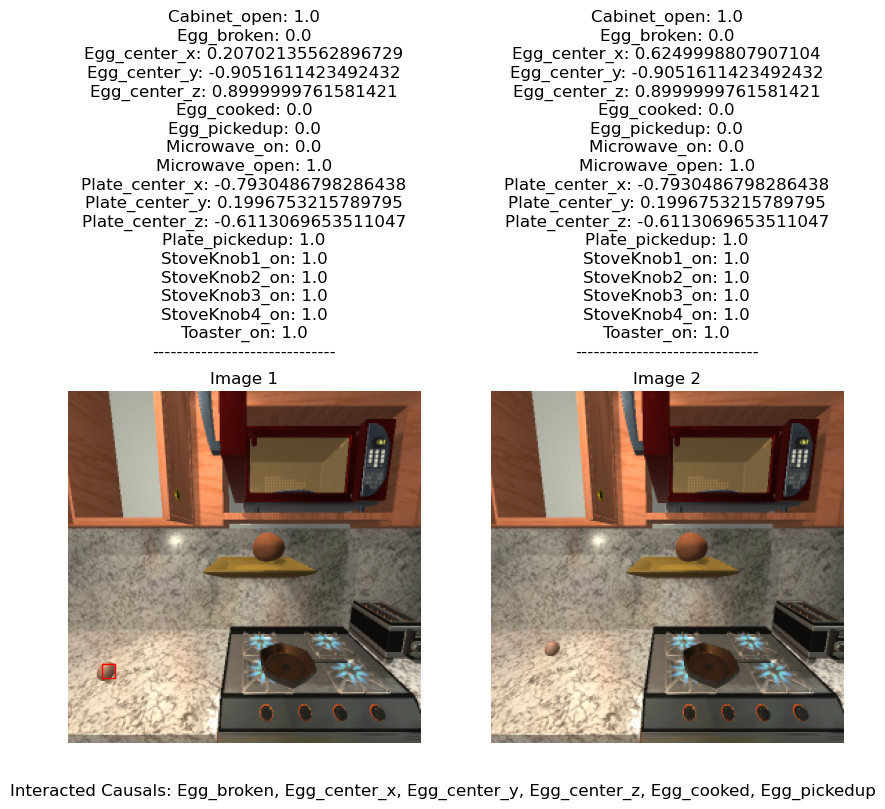

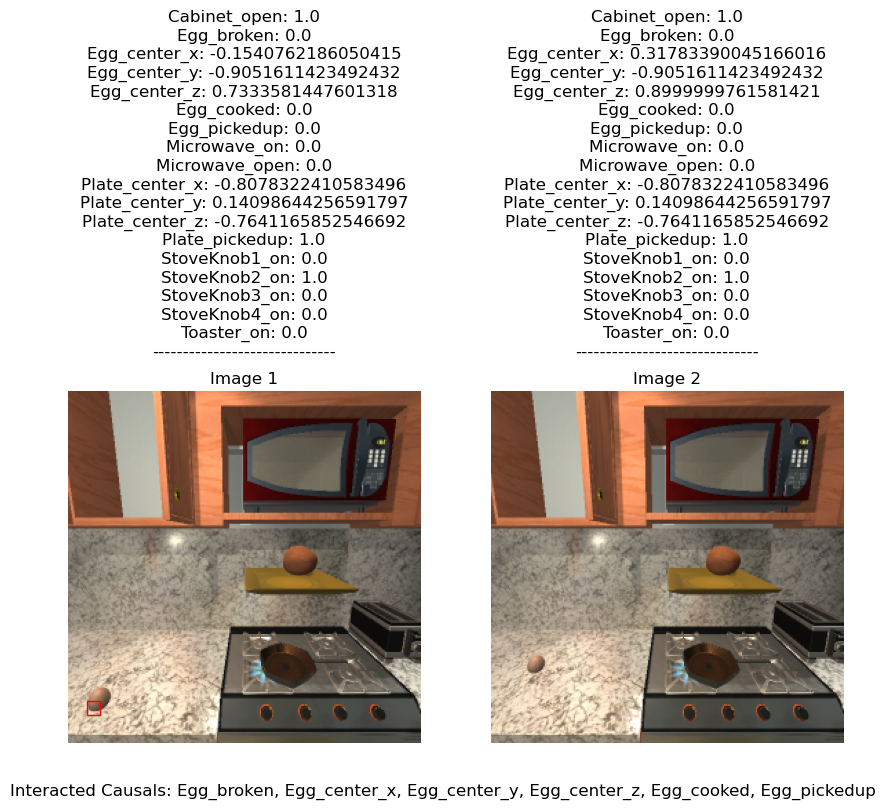

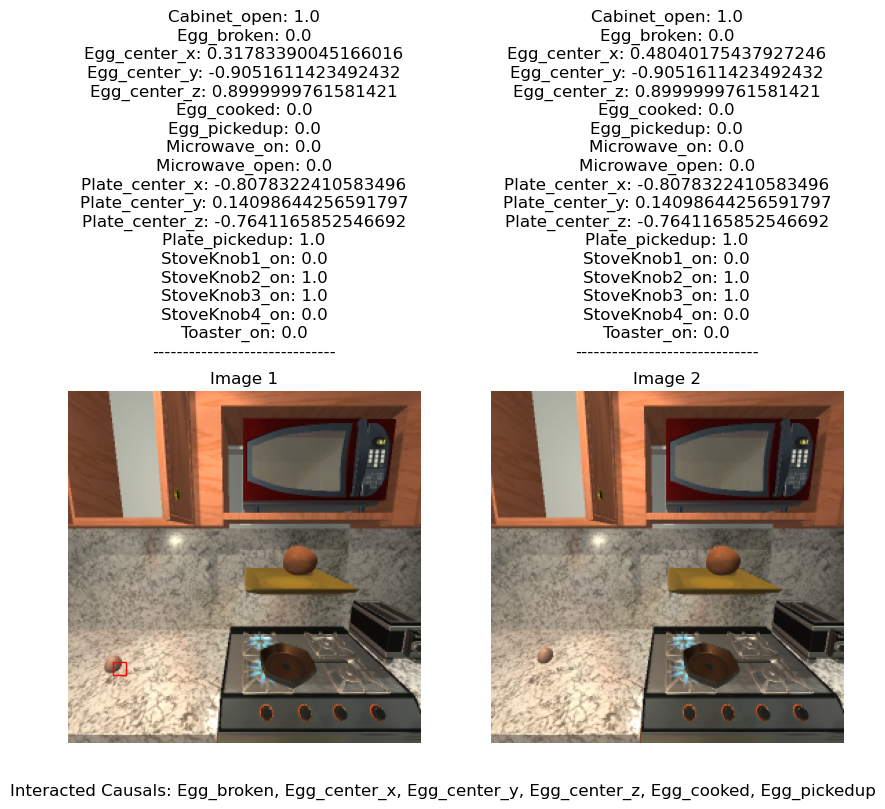

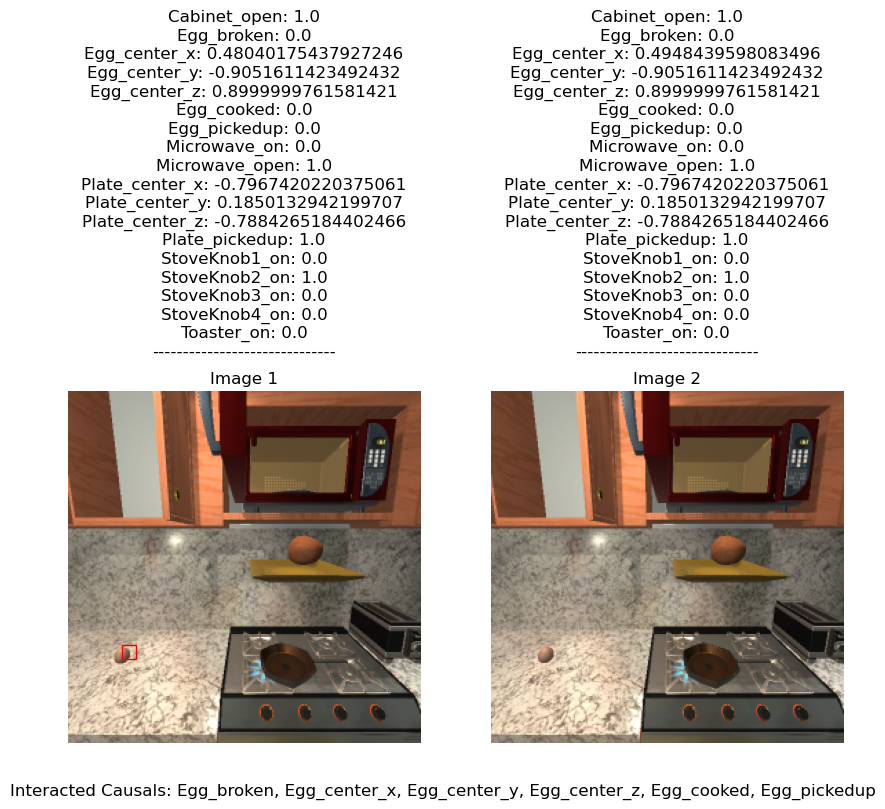

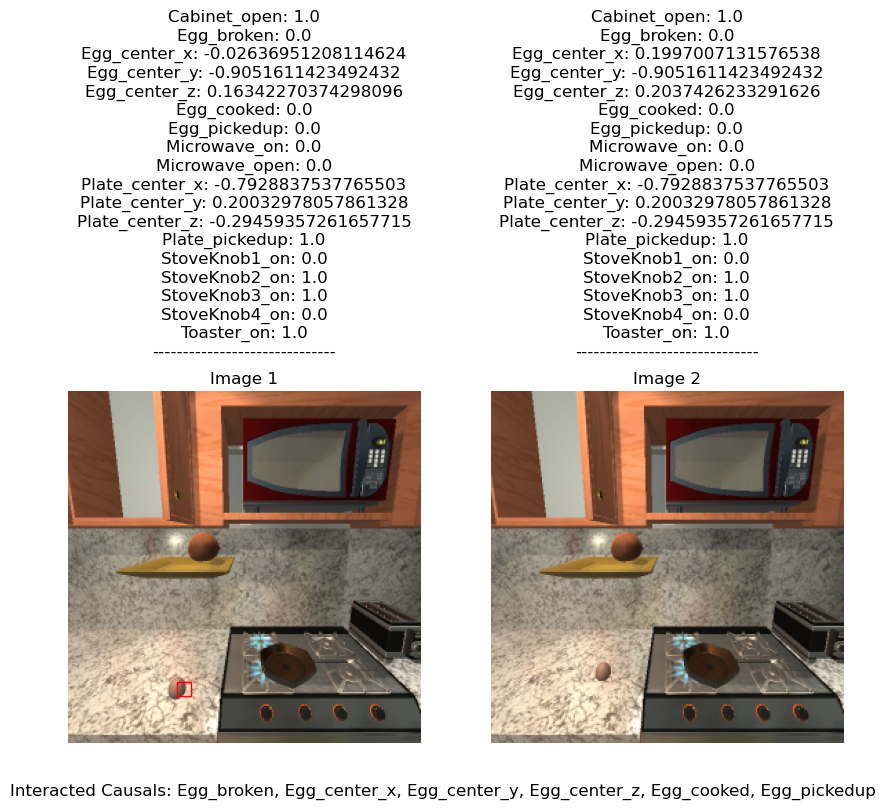

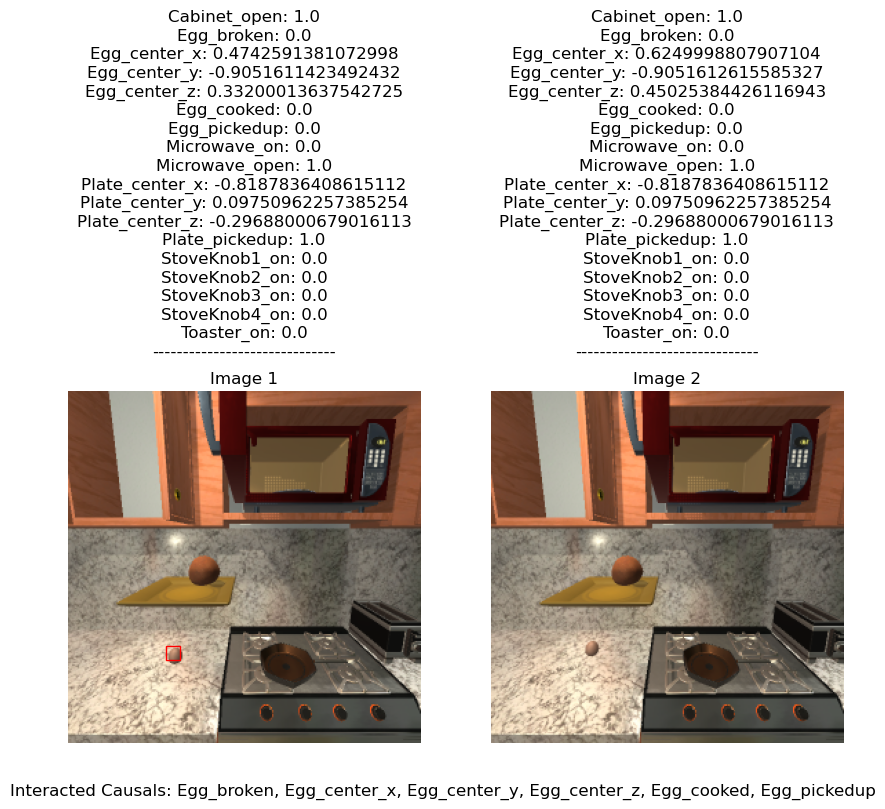

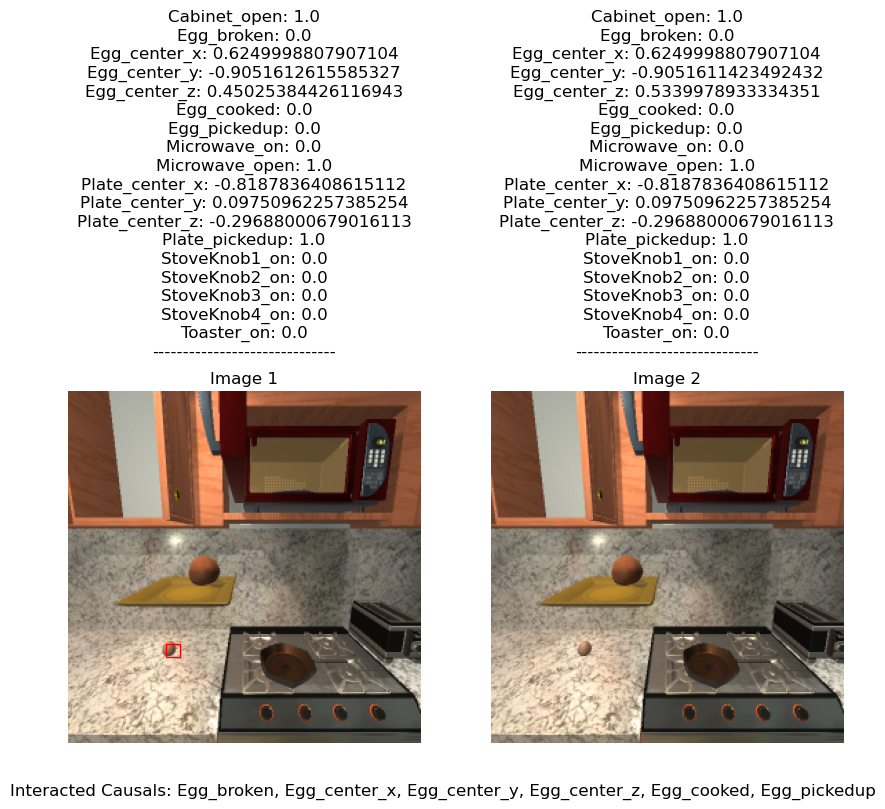

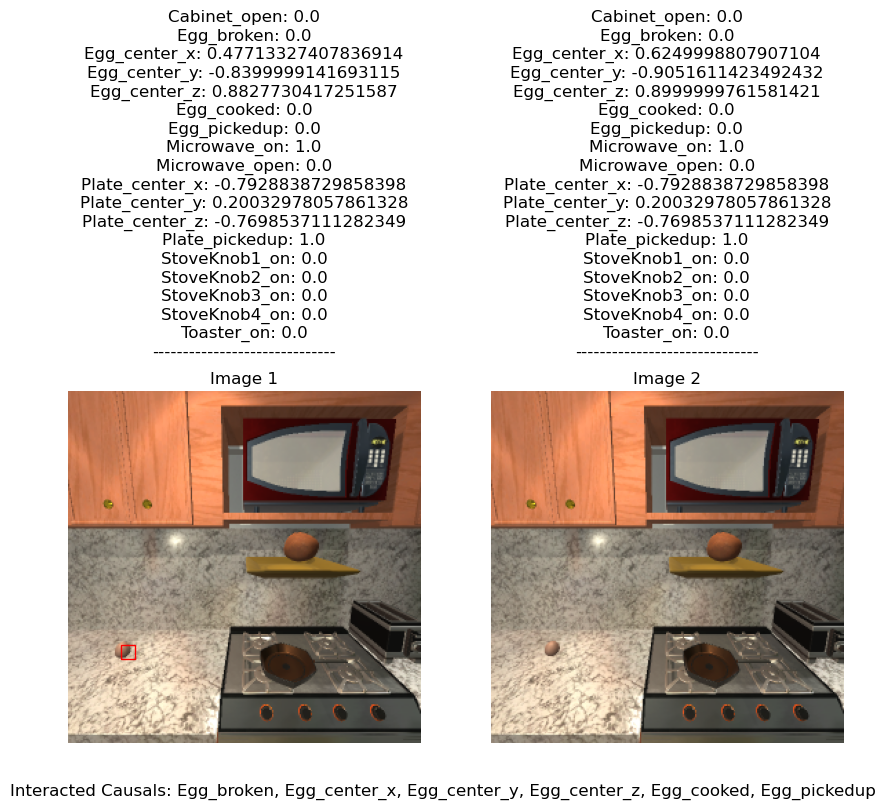

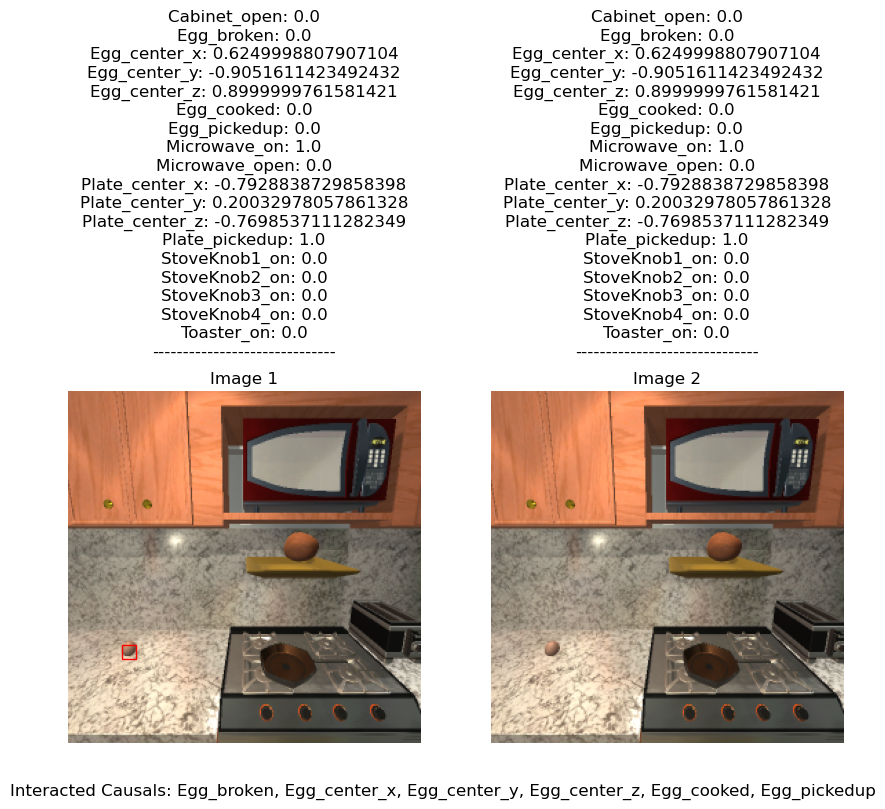

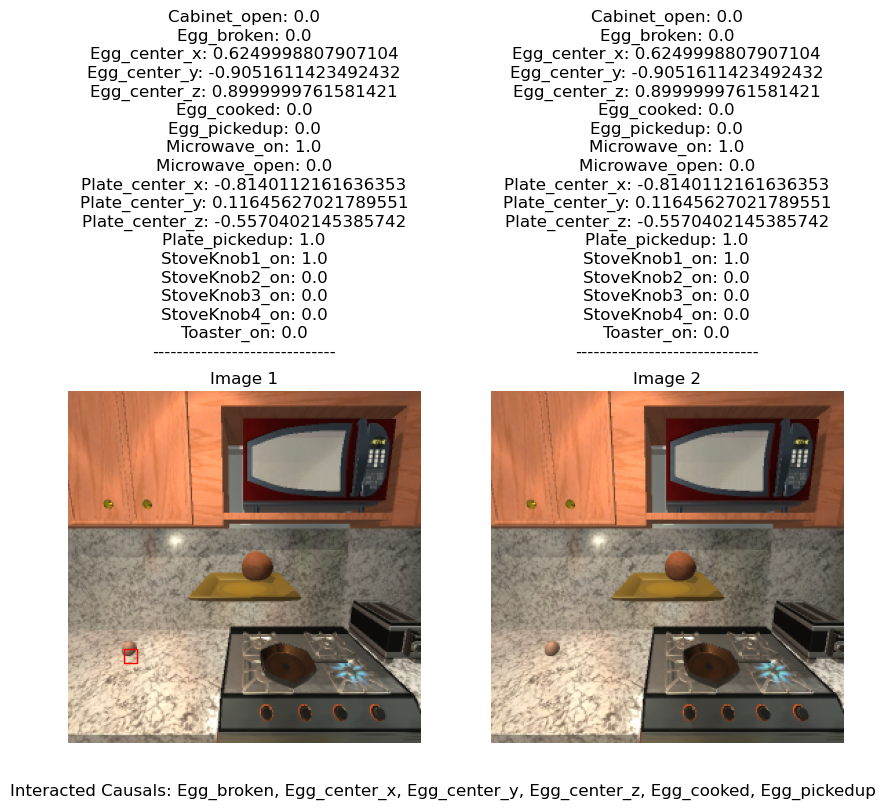

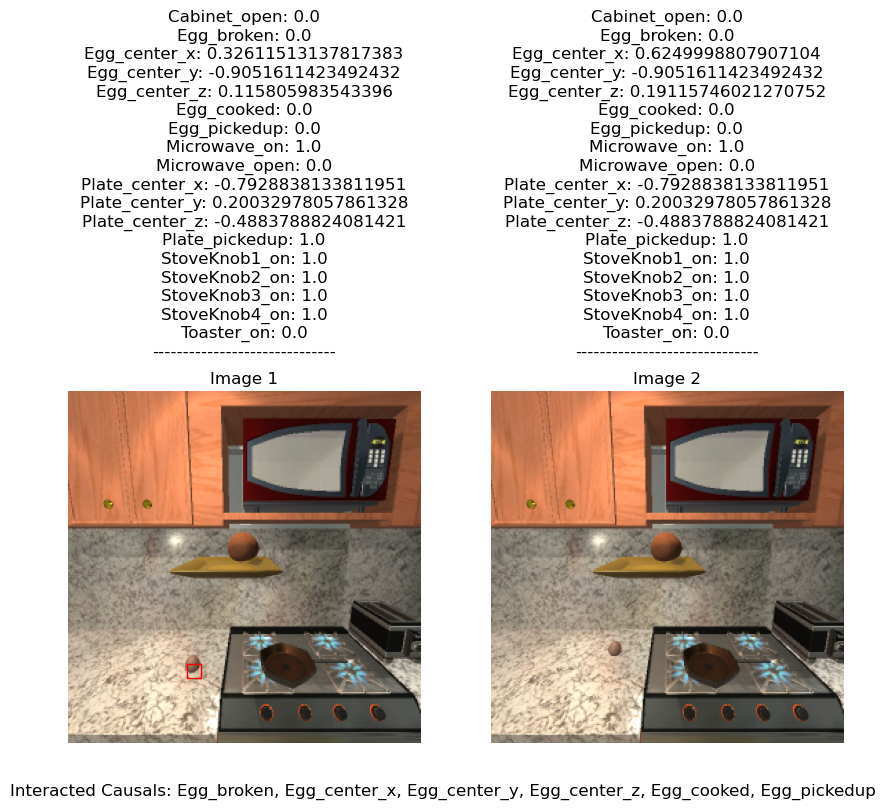

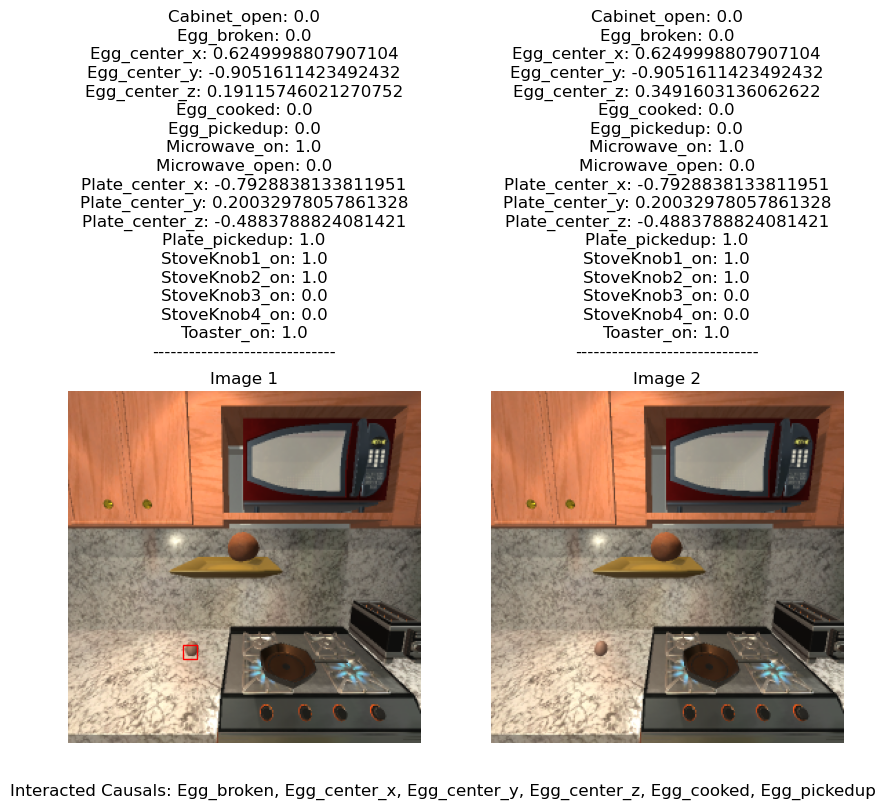

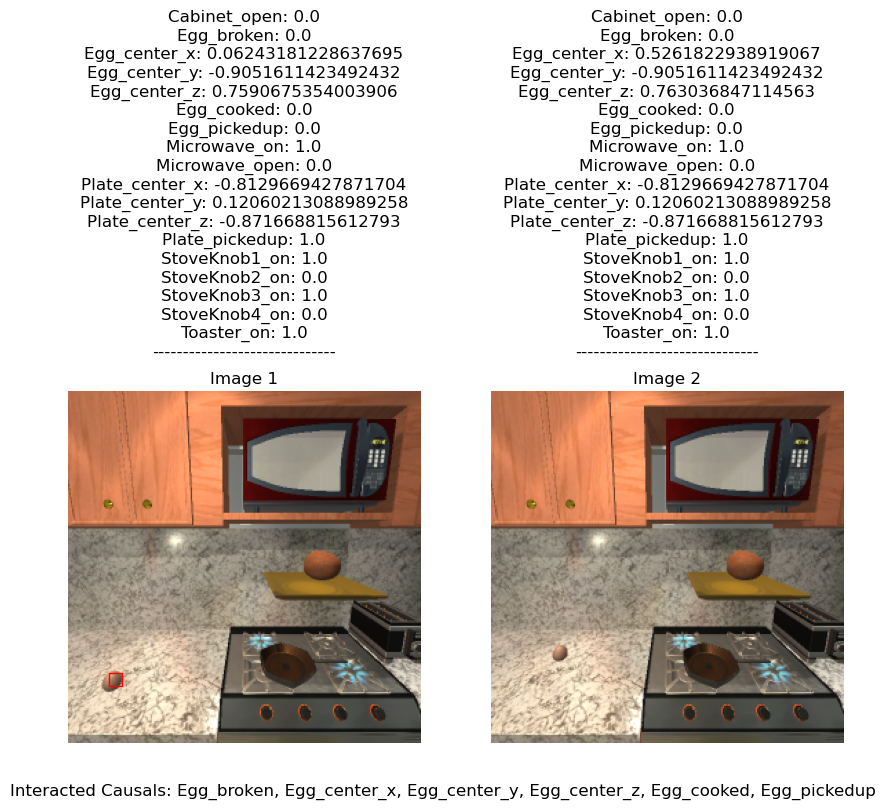

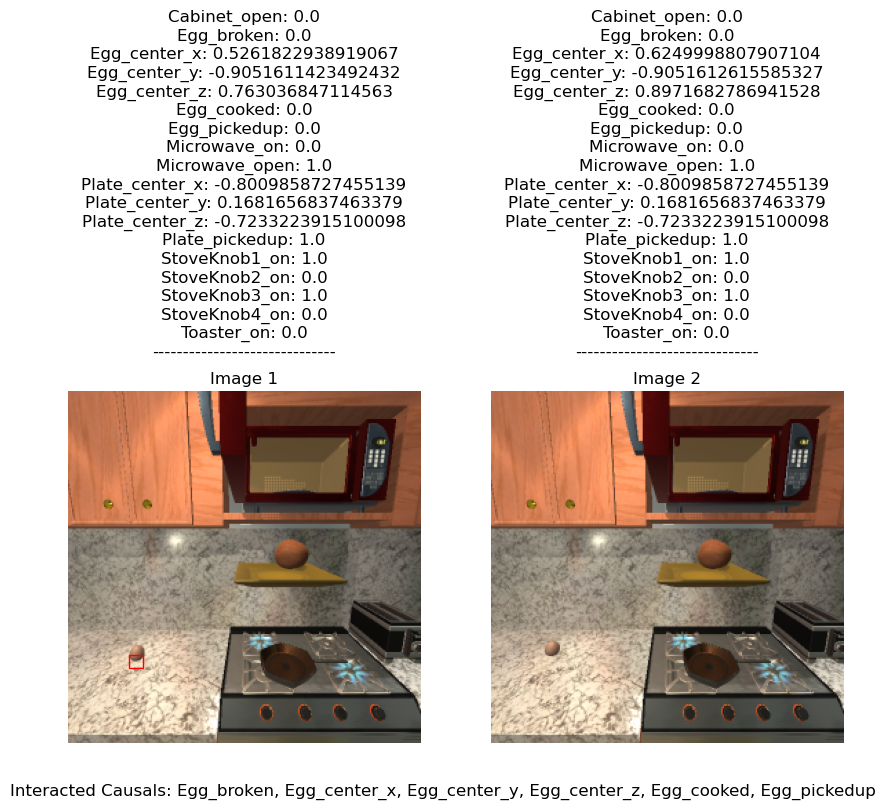

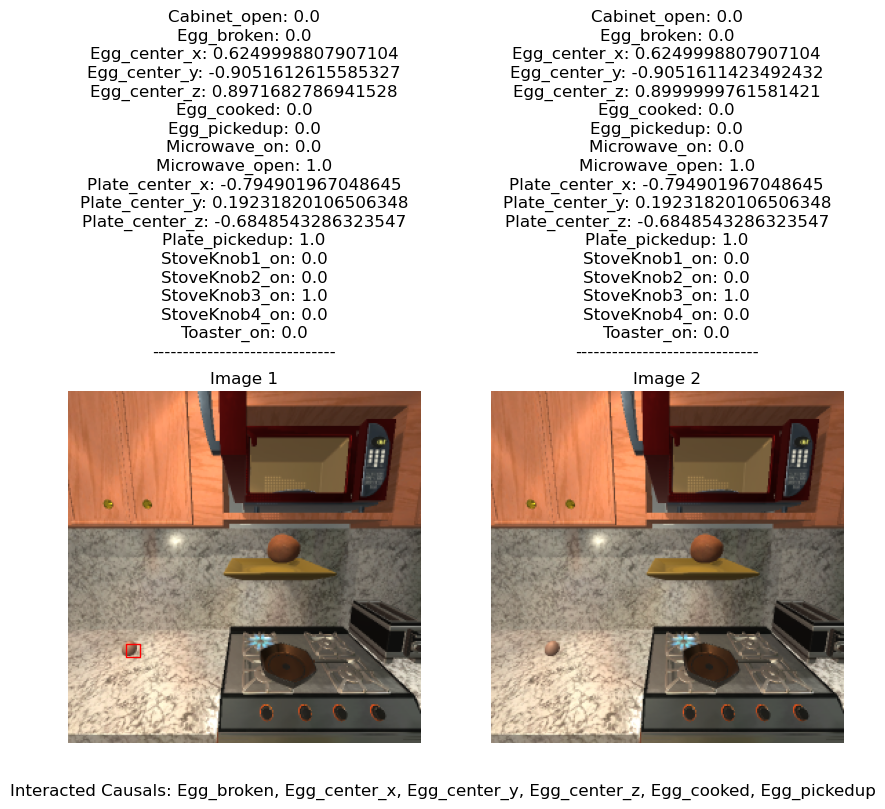

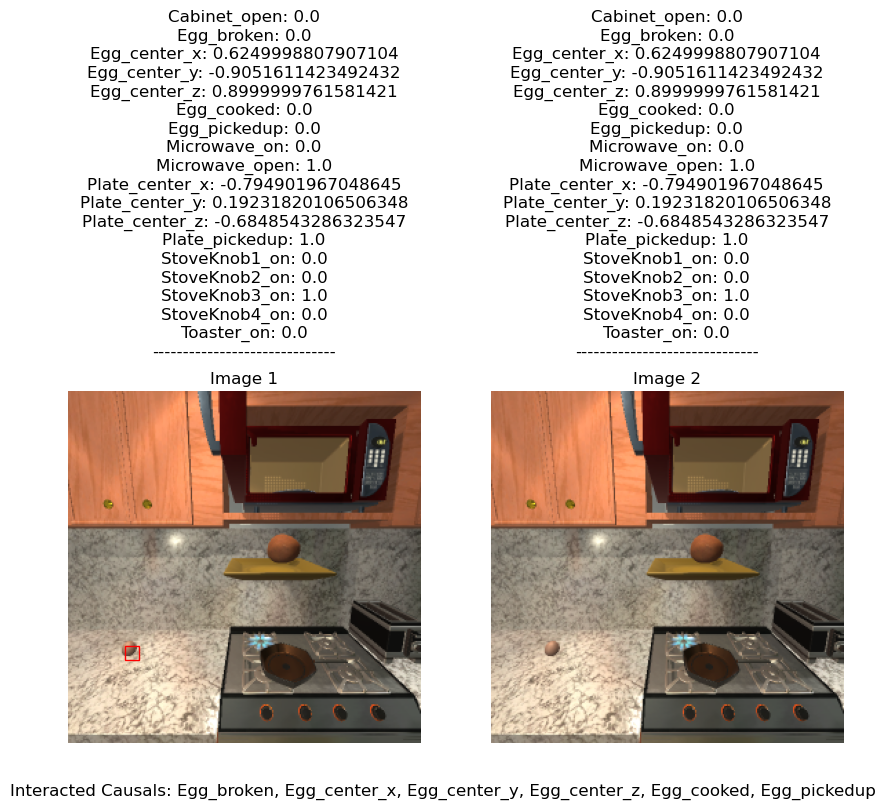

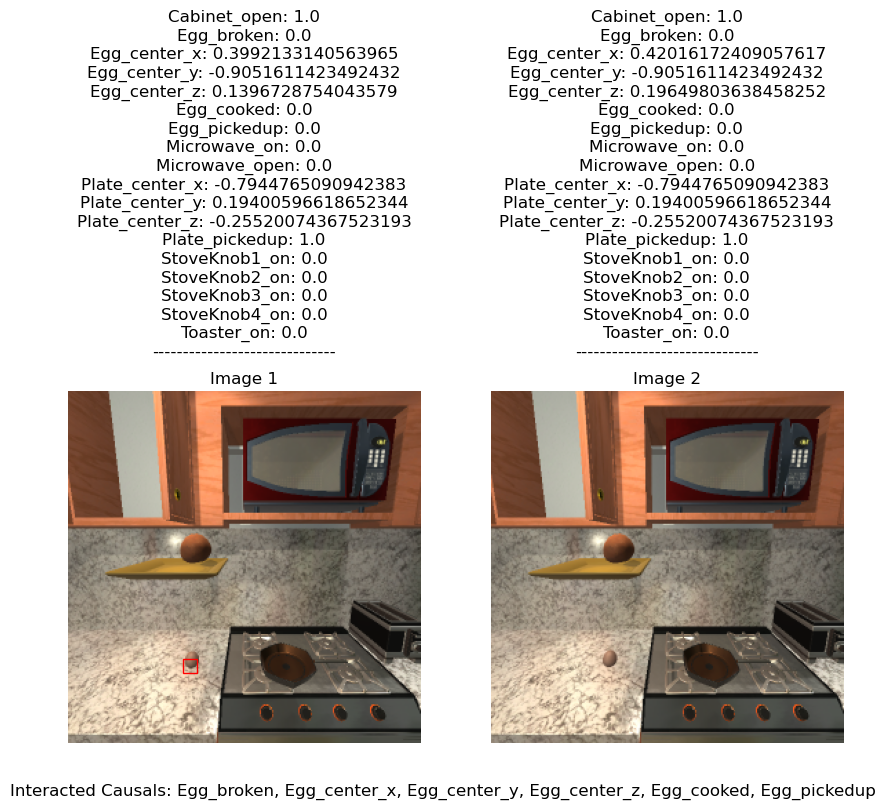

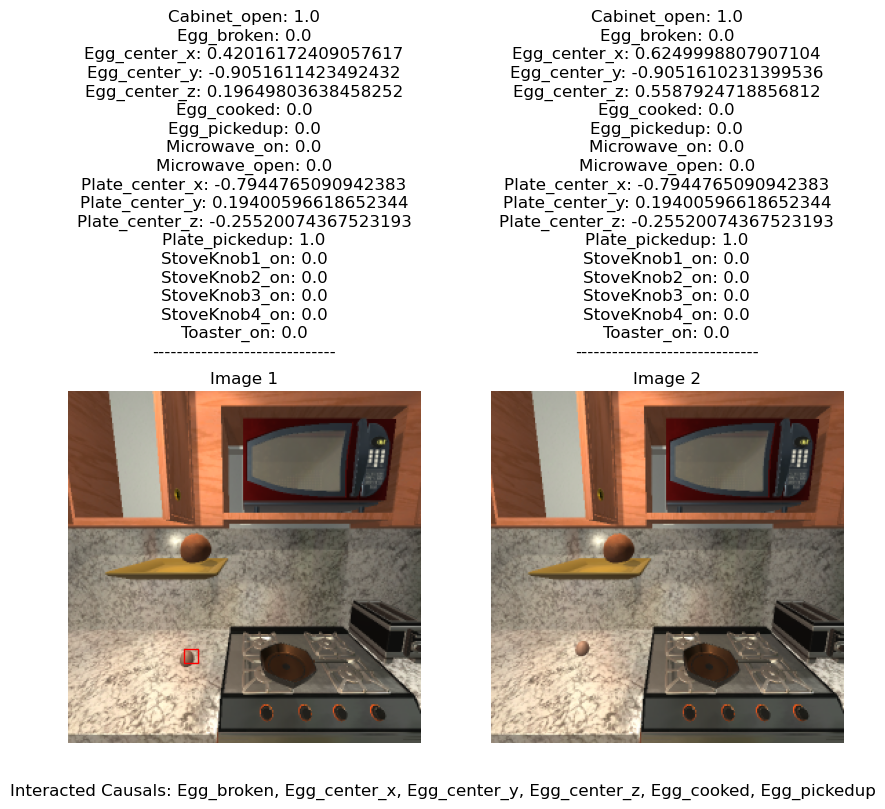

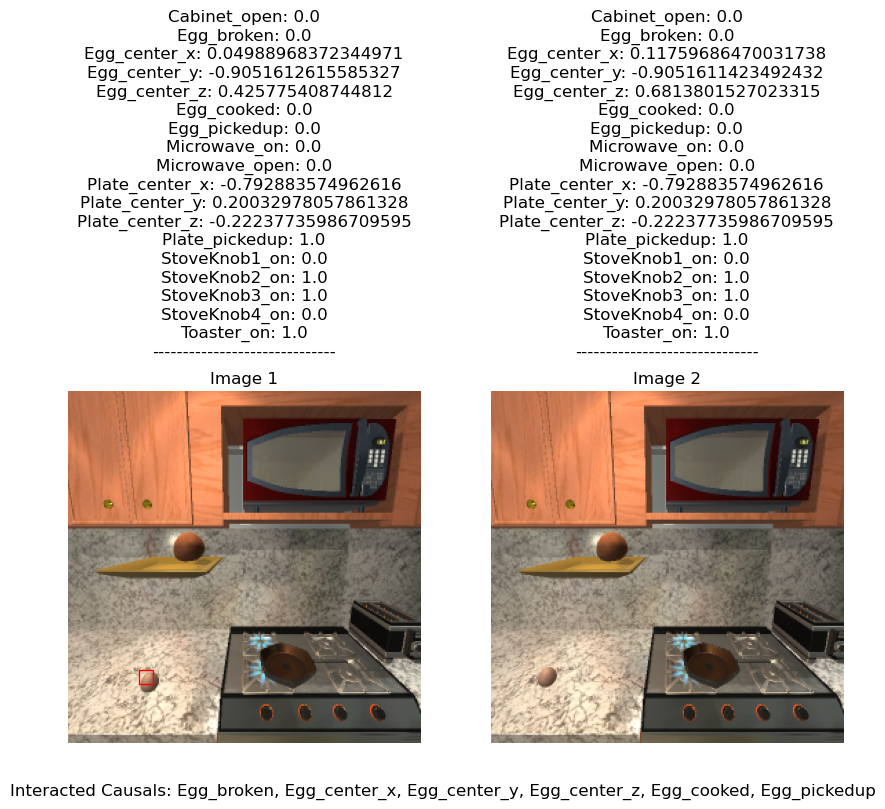

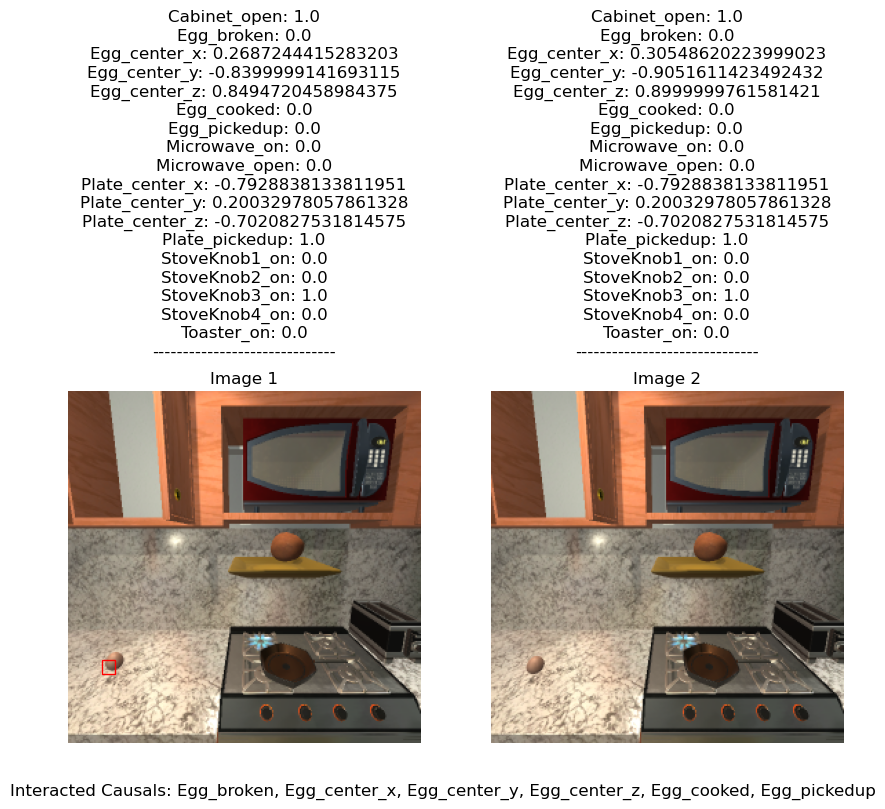

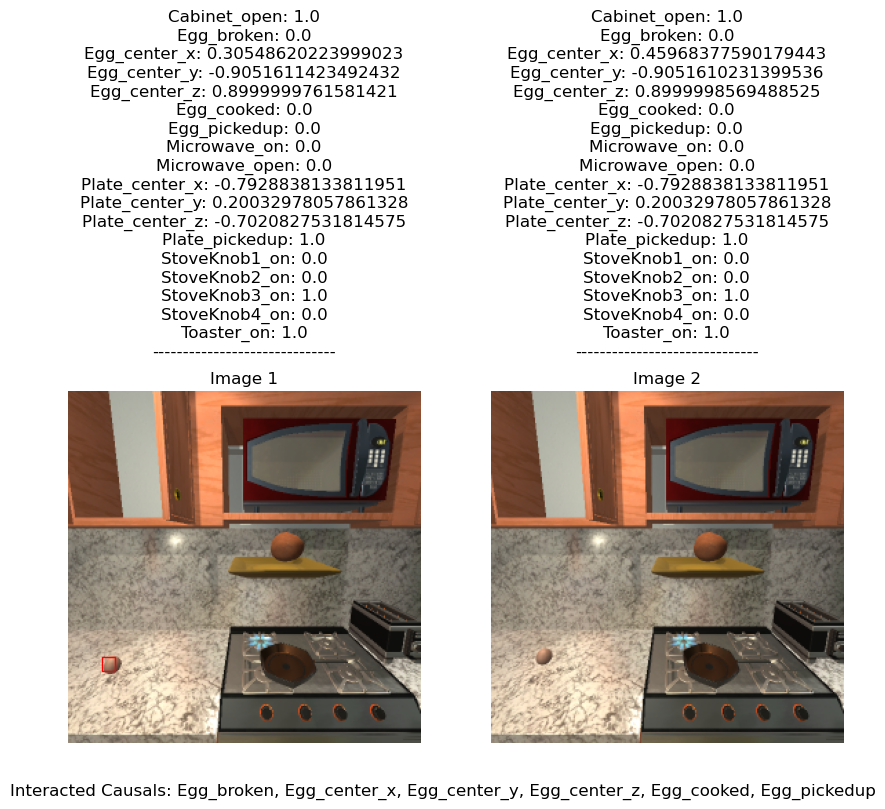

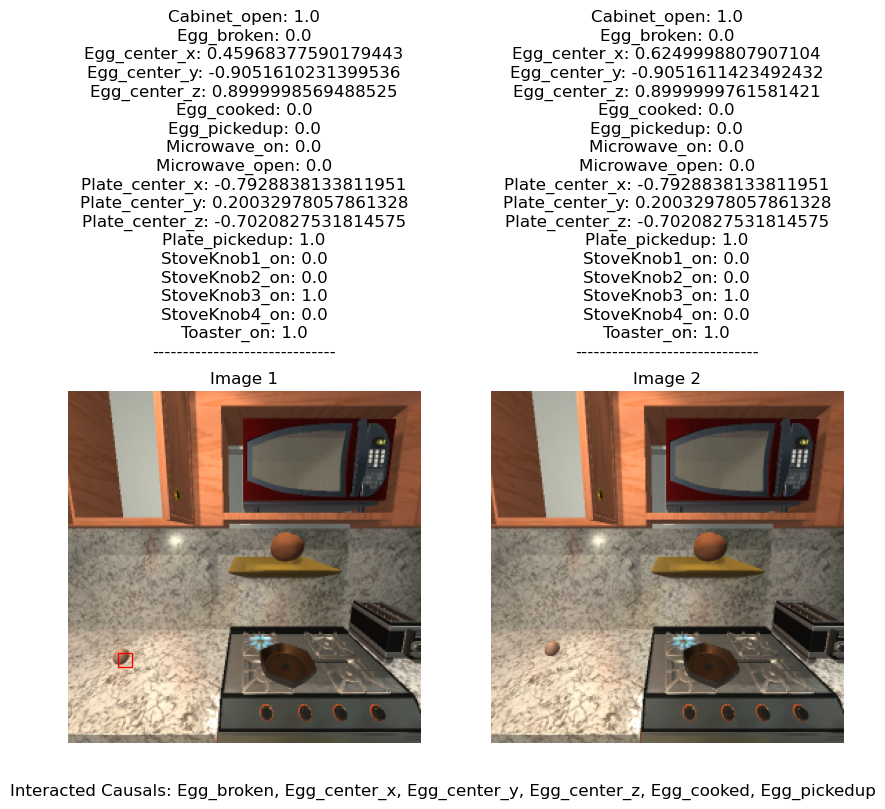

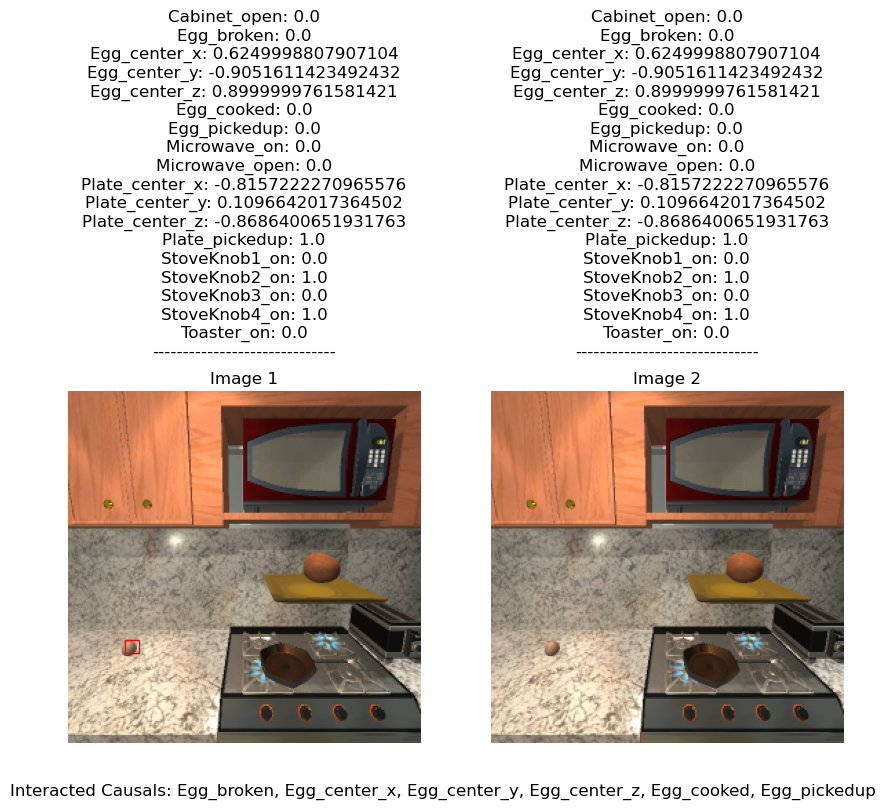

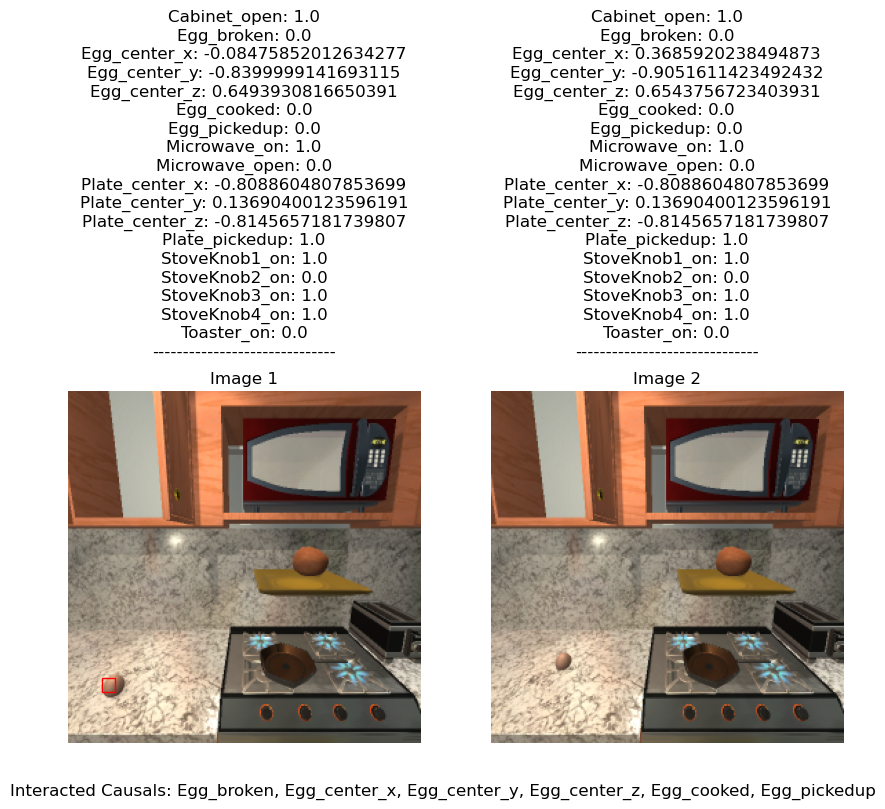

In [13]:
causal_variable_names = [
    "Cabinet_open",
    "Egg_broken",
    "Egg_center_x",
    "Egg_center_y",
    "Egg_center_z",
    "Egg_cooked",
    "Egg_pickedup",
    "Microwave_on",
    "Microwave_open",
    "Plate_center_x",
    "Plate_center_y",
    "Plate_center_z",
    "Plate_pickedup",
    "StoveKnob1_on",
    "StoveKnob2_on",  # Assuming that different StoveKnobs are represented by the same label here
    "StoveKnob3_on",
    "StoveKnob4_on",
    "Toaster_on"
]


import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_samples_improved(dataset, num_samples=25):
    # Extract data
    for i in range(num_samples):
        images, actions, causal_vars, latents = dataset[i]

        # Process images
        img_sequence = images.permute(0, 2, 3, 1)  # Change to [2, 256, 256, 3]
        img_sequence = (img_sequence + 1) / 2

        # Process action
        action = actions.squeeze()  # Remove unnecessary dimensions
        action_pixel = ((action + 1.0) / 2.0 * 256).int()

        latent_dicts = [{name: val.item() for name, val in zip(causal_variable_names, latent.squeeze())} for latent in latents]

        # Display images with action
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        for j in range(img_sequence.shape[0]):
            axs[j].imshow(img_sequence[j].numpy())
            axs[j].set_title(f"Image {j+1}")
            bbox = axs[j].get_position()
            # Pretty print latent variables for each image, centered above each image
            fig.text(bbox.x0 + bbox.width / 2, bbox.y1 + 0.07, '\n'.join([f"{name}: {val}" for name, val in latent_dicts[j].items()]) + '\n' + '-'*30, ha='center', fontsize=12)
            axs[j].axis('off')
            if j == 0:  # Add action indicator to first image
                rect = patches.Rectangle((action_pixel[1]-5, action_pixel[0]-5), 10, 10, linewidth=1, edgecolor='r', facecolor='none')
                axs[j].add_patch(rect)

        # Display causal variables
        causal = causal_vars.squeeze()
        interacted_causals = [name for name, val in zip(causal_variable_names, causal) if val == 1]
        plt.figtext(0.5, 0.04, f"Interacted Causals: {', '.join(interacted_causals)}", ha="center", fontsize=12)
        plt.show()

# Visualize a few samples with improved visualization
# dataset = torch.load('test.pt')
visualize_samples_improved(egg_cooked_subset)